# Restricted Boltzmann Machine Defintion


### Import PyTorch library

In [19]:
import torch
import torch.nn as nn

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

### the Restricted Boltzmann Machine architecture

In [20]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# 
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k, batch_size):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """
        self.i = 0
        self.K = k
        self.batch_size = batch_size

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.randn(k, n_hid, n_vis)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.zeros(k, 1, n_vis)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.zeros(1, n_hid)  # fake dimension for the batch = 1

        if torch.cuda.is_available():
            self.W = self.W.cuda()
            self.v_bias = self.v_bias.cuda()
            self.h_bias = self.h_bias.cuda()
    
    def lr(self):
        """
        return the learning rate of the model, lr is based on batchsize
        :return: constant/batch_size
        """
        return 0.01 / self.batch_size

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h

        temp = torch.transpose(self.W, 1, 2)

        wxs = []
        for i in range(self.K):
            wxs.append(torch.mm(x[i], temp[i]))
            
        wx = torch.stack(wxs)
        wx_sum = torch.sum(wx, 0)

        # Expand the mini-batch
        activation = wx_sum + self.h_bias.expand_as(wx_sum)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        exponents = []
        for k in range(self.K):
            wy = torch.mm(y, self.W[k])
            activation = wy + self.v_bias[k].expand_as(wy)
            exponents.append(torch.exp(activation))

        exponent_tensor = torch.stack(exponents)
        exponent_sum = torch.sum(exponent_tensor, 0)
        probs = []
        for k in range(self.K):
            p_v_k_given_h = exponent_tensor[k] / exponent_sum
            probs.append(p_v_k_given_h)

        p_v_given_h = torch.stack(probs)
        # todo multinomial
        bern = torch.bernoulli(p_v_given_h)
        return p_v_given_h, bern


    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        ph0_K = torch.stack([ph0 for _ in range(self.K)])
        phk_K = torch.stack([phk for _ in range(self.K)])

        poss = []
        negs = []
        for i in range(self.K):
            poss.append(torch.mm(torch.transpose(v0, 1, 2)[i], ph0_K[i]))
            negs.append(torch.mm(torch.transpose(vk, 1, 2)[i], phk_K[i]))

        pos = torch.stack(poss)
        neg = torch.stack(negs)

        w_extra = torch.transpose(pos - neg, 1, 2)
        v_extra = torch.sum((v0 - vk), 1)
        h_extra = torch.sum((ph0 - phk), 0)

        # Approximate the gradients with the CD algorithm
        self.W -= self.lr() * w_extra

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias -= self.lr() * v_extra.unsqueeze(1)
        self.h_bias -= self.lr() * h_extra
        self.i += 1

In [21]:
cuda = torch.device('cuda')

## General Imports

In [22]:
import numpy as np
import pickle as pickle
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm, trange
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

## Reading in steamdata

In [23]:
def load_interactions(path, n_splits=5):
    """
    load in the interactions_splits.pkl.gz file with our data for the various users
    :param path: path location of the data
    :param n_splits: split in n_split splits
    :return: interactions
    """
    df = pd.read_pickle(os.path.join(os.getcwd(), path))
    df[['interactions', 'train', 'val', 'test']] = df[['interactions', 'train', 'val', 'test']].applymap(lambda x: np.array(x, dtype=np.int32))
    interactions_dict = {}
    for split in trange(n_splits):
        for column in ['train', 'val', 'test']:
            interactions_dict[split, column] = pd.DataFrame({
                'user_id': df['user_id'],
                'steam_id': df['steam_id'],
                'item_id': df[column].apply(lambda x: x[split, 0]),
                'playtime_forever': df[column].apply(lambda x: x[split, 1]),
                'playtime_2weeks': df[column].apply(lambda x: x[split, 2])})
    return interactions_dict

### Reading and showning train data

In [29]:
interactions = load_interactions("./data-cleaned/interactions_splits.pkl.gz")
interactions[0, 'train'].head()

100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


,user_id,steam_id,item_id,playtime_forever,playtime_2weeks
0,76561197981203305,76561197981203305,"[1461, 1999, 1984, 761, 2820, 819, 187, 506, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,bosslucek,76561198029968002,"[4014, 1018, 3632, 2843, 2755, 219, 6245, 2621...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,icantwait,76561197971666535,"[886, 2010, 419, 2217, 1293, 2809, 802, 155, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,76561198067911521,76561198067911521,"[1849, 1038, 229, 400, 1386, 1437, 1363, 515, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,kushziller,76561198021307778,"[2883, 401, 2243, 4408, 3966, 1487, 1888, 2708...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Reading and showing list of games

In [30]:
games = pd.read_pickle(os.path.join(os.getcwd(), "./data-cleaned/games.pkl.gz"))
games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,users_count
0,Rockstar Games,[Action],Grand Theft Auto: Episodes from Liberty City,Grand Theft Auto: Episodes from Liberty City,http://store.steampowered.com/app/12220/Grand_...,2010-04-12,"[Open World, Action, Third Person, Multiplayer...",NaN,http://steamcommunity.com/app/12220/reviews/?b...,"[Single-player, Multi-player]",19.99,False,12220,Rockstar North / Toronto,Mostly Positive,NaN,7597
1,Valve,[Action],Half-Life,Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",NaN,http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,96,7575
2,"Trion Worlds, Inc.","[Action, Free to Play, Massively Multiplayer, ...",Defiance,Defiance,http://store.steampowered.com/app/224600/Defia...,2014-06-04,"[Free to Play, Action, Open World, Massively M...",NaN,http://steamcommunity.com/app/224600/reviews/?...,"[Multi-player, MMO, Co-op, Steam Trading Cards...",Free to Play,False,224600,"Trion Worlds, Inc.",Mostly Positive,64,7539
3,Bohemia Interactive,"[Action, Simulation, Strategy]",Arma 3,Arma 3,http://store.steampowered.com/app/107410/Arma_3/,2013-09-12,"[Simulation, Military, Multiplayer, Realistic,...",NaN,http://steamcommunity.com/app/107410/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",39.99,False,107410,Bohemia Interactive,Very Positive,74,7527
4,Unknown Worlds Entertainment,"[Action, Indie, Strategy]",Natural Selection 2,Natural Selection 2,http://store.steampowered.com/app/4920/Natural...,2012-10-30,"[Multiplayer, Strategy, FPS, Team-Based, Actio...",NaN,http://steamcommunity.com/app/4920/reviews/?br...,"[Multi-player, Online Multi-Player, Steam Achi...",9.99,False,4920,Unknown Worlds Entertainment,Very Positive,80,7502


In [31]:
train0 = interactions[0, 'train']
test0 = interactions[0, 'test']
val0 = interactions[0, 'val']

In [32]:

train1 = interactions[1, 'train']
test1 = interactions[1, 'test']
val1 = interactions[1, 'val']

In [33]:

train2 = interactions[2, 'train']
test2 = interactions[2, 'test']
val2 = interactions[2, 'val']

# Sparse Matrix

### Method to create Sparse Matrix

In [34]:
def score_playtime(playtime):
    """
    give a game a rating score between 0 and 4 
    :param playtime: the playtime to give a score by
    :return: 0,1,2,3 or 4 based on playtime
    """
    if playtime < 120:
        # less than 2 hrs
        return 0
    elif playtime < 240:
        # less than 4 hrs
        return 1
    elif playtime < 600:
        # less than 10 hrs
        return 2
    elif playtime < 24*60:
        # less than 24 hrs
        return 3
    else:
        return 4

from os import path
if not path.isfile('index_random_ordering.pkl'):
    import random
    index_random_list =list(range(games.shape[0]))
    random.shuffle(index_random_list)
    # print(index_random_list)
    file = open("index_random_ordering.pkl", "wb")
    pickle.dump(index_random_list, file)
    file.close()
else:
    f = open("index_random_ordering.pkl", "rb")
    index_random_list = pickle.load(f)
    f.close()

def shuffle_item_index(items):
    global index_random_list
    return [index_random_list[item] for item in items]

def invert_items(items, max_item: int):
    return [max_item - item for item in items]

#Create scipy csr matrix
def get_sparse_matrix(df):
    """
    generate a sparse matrix of user-game pairs based on our dataframe
    :param df: the dataframe to base the sparse matrix upon
    :return: a sparse matrix of user-game pairs with a score based on playtime
    """
    shape = (df.shape[0], games.shape[0])
    max_game = games.shape[0] - 1
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        user = idx
        items = row['item_id']
        # items = invert_items(items, max_game)
        items = shuffle_item_index(items)
        score = row["playtime_forever"] + 2* row["playtime_2weeks"]
        
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([score_playtime(score[i]) for i in range(len(items))])
    # create csr matrix
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


### generate the Sparse Matrisces for train AND test

In [35]:
train_matrix = get_sparse_matrix(train0)
test_matrix = get_sparse_matrix(test0)
val_matrix = get_sparse_matrix(val0)
train_matrix

<54190x7276 sparse matrix of type '<class 'numpy.intc'>'
	with 1407708 stored elements in Compressed Sparse Row format>

### Method to convert Sparse Matrix to pytorch tensor

In [36]:

# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X, k=5):
    """
    turn the Sparse scipy matrix into a sparse pytorch tensor
    :param X: the Sparse scipy matrix
    :param k: the amount of possible ratings we have given to our user-game pairs
    :return: a sparse 3-D pytorch tensor of dimensions game-user-rating
    """
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.DoubleTensor(values)
    tensor_list = []

    for index in range(k):
        value = index
        yeet = torch.where(v == value, 2., 1.)
        shape = coo.shape
        tensor = torch.sparse.DoubleTensor(i, yeet, torch.Size(shape)) 
        if torch.cuda.is_available():
            tensor = tensor.cuda()

        tensor_list.append(tensor)

    tensor = torch.stack(tensor_list) 
    return tensor

# Train model

In [37]:
def score_model(rbm: RBM, batch_size, train_matrix, test_matrix):
    """
    calculate an error for the output of our rbm for the unseen (and untrained upon) test-values
    :param rbm: the model for which we test values
    :param batch_size: the batchsize used for training/testing
    :param train_matrix: the original input with which we try to get our test-values
    :param test_matrix: the values we try for our model to acquire based on train_matrix
    :return: the RMSE for our test-values
    """
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0] - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)

        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()

        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            _, v = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.mean((vt[vt > -1] - v[vt > -1])**2) * len(vt > -1) 
            s += len(vt > -1)

    return torch.sqrt(test_recon_error / s)


def create_rbm(train_matrix, test_matrix, n_hidden, batch_size, epochs, rbm=None, k=5, train_errors=[], test_errors=[]) -> RBM:
    """
    generate and train an RBM based on train_matrix as input
    :param train_matrix: the input upon which our model is trained
    :param test_matrix: the input upon which our model is validated
    :param n_hidden: the amount of hidden features our model uses
    :param batch_size: the batchsize we use
    :param epochs: the amount of epochs we will be running
    :param rbm: an optional variable that if not None trains a pre-generated model further instead of generating a new one
    :param k: the amount of possible ratings we have given to our user-game pairs
    :return: a trained RBM
    """
    n_vis = train_matrix.shape[1]
    if rbm is None:
        rbm = RBM(n_vis, n_hidden, k, batch_size)
    
    oldhr, oldr, oldndcg = 0, 0, 0
    # hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
    # print("pre training", np.average(hr), np.average(r), np.average(ndcg))

    print("start training")
    for epoch in range(epochs):
        rbm.train()
        train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
        s = 0
        
        for user_id in range(0, train_matrix.shape[0] - batch_size, batch_size):
            training_sample = train_matrix[user_id : user_id + batch_size]
            v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)

            v0 = v0.to_dense()
            v0 = v0.sub(1)
            
            vk = v0.detach().clone()

            ph0, _ = rbm.sample_h(v0)
            # todo cd = 3
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            vk[v0 < 0] = v0[v0 < 0]
                
            phk, _ = rbm.sample_h(vk)

            rbm.train_model(v0, vk, ph0, phk)
            
            train_recon_error += torch.mean((v0[v0 > -1] - vk[v0 > -1])**2) * len(v0 > -1)
            s += len(v0 > -1)
            
        train_errors.append(torch.sqrt(train_recon_error / s))

        rbm.eval()
        test_errors.append(score_model(rbm, batch_size, train_matrix, test_matrix))


            

    import matplotlib.pyplot as plt
    # Plot the RMSE reconstruction error with respect to increasing number of epochs
    plt.clf()
    plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
    plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'steam-cleaned-{n_hidden}-{batch_size}-{epochs}.jpg')

    return rbm, train_errors, test_errors



## HR / Recall / NDCG Function Definitions

### Vanilla Recommendations

In [38]:
def compute_hr(train_matrix, test_matrix, rbm, k=10, rating_cutoff=-1, p=False):
    """
    compute the various metrics of our model, hr, recall and ndcg
    :param train_matrix: the input wich our user already has
    :param test_matrix: the games we are trying to recommend to each user
    :param rbm: our model used to make recommendations
    :param k: the amount of recommendations we are going to give
    :param batch_size: UNUSED, uses rbm.batch_size instead
    :return: hitrates, recall, nDCG as an array, use np.average to get value
    """
    hitrates = []
    recall = []
    nDCG = []

    recommended_games_set = set()
    # for loop - go through every single user
    # for id_user in tqdm(range(0, train_matrix.shape[0] - rbm.batch_size, rbm.batch_size)): # - batch_size, batch_size):
    for id_user in range(0, train_matrix.shape[0] - rbm.batch_size, rbm.batch_size): # - batch_size, batch_size):
        v = train_matrix[id_user:id_user + rbm.batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + rbm.batch_size]  # target
        if vt.getnnz() == 0:
            continue

        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)
        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)

        if torch.cuda.is_available():
            vt = vt.cuda()
            v = v.cuda()

        # ground truth
        ratings, users, movies = (vt > 0).nonzero(as_tuple=True)

        indices = torch.stack([users, movies])
        shape = (rbm.batch_size, train_matrix.shape[1])
        target = torch.sparse.LongTensor(indices, torch.add(ratings, 1), torch.Size(shape))
        target_dense = target.to_dense()

        target_recommended = torch.argsort(target_dense, 1, descending=True)
        

        # predicted
        _, h = rbm.sample_h(v)
        recommended, _ = rbm.sample_v(h)

        scaled_tensors = [recommended[0]]
        for i in range(1, rbm.K):
            scaled_tensors.append(recommended[i] * (i+1))
        recommended_scaled = torch.stack(scaled_tensors)
        recommended_summed = torch.sum(recommended_scaled, 0)
        predicted_rating, predicted_movie = torch.topk(recommended_summed, k)


        for user in range(rbm.batch_size):
            # all recommendations
            user_ratings = torch.index_select(target_dense[user], 0, target_recommended[user])
            user_target = target_recommended[user][user_ratings > 0].cpu().tolist()

            # user_target = target_recommended[user][target_rating[user] > rating_cutoff].cpu().tolist()
            user_pred = predicted_movie[user].cpu().tolist()

            recommended_games_set = recommended_games_set.union(set(user_pred))

            counter = 0
            total = min(k, len(user_target))
            for target in user_target:
                if target in user_pred:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(user_target)))])
            dcg = 0
            for i, r in enumerate(user_pred):
                if r in user_target:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    if p:
        print(recommended_games_set)
        print(len(recommended_games_set))
    return hitrates, recall, nDCG

In [39]:
# rbm10 = create_rbm(train_matrix, test_matrix, 1000, 10000, 10)

In [40]:
# rbm20 =create_rbm(train_matrix, test_matrix, 1000, 10000, 10, rbm10)

### Popularity

In [41]:
def get_pop(train_df):
    """
    get the items based on there occurence in train_df
    :param train_df: the train_data
    :return: list ordered from most to least common item
    """
    popularity = train_df.explode('item_id')['item_id'].value_counts()
    l = list(popularity.index)
    global index_random_list
    return [index_random_list[item] for item in l]
    


pop = get_pop(train0)

In [43]:
def compute_hr2(train_matrix, test_matrix, pops, k=10, rating_cutoff=-1, p=False, batch_size = 2000):
    """
    compute the various metrics of popularity: hr, recall and ndcg
    :param train_matrix: the input wich our user already has
    :param test_matrix: the games we are trying to recommend to each user
    :param pops: the list of the ordered most items
    :param k: the amount of items to recommend
    :param rating_cutoff: UNUSED 
    :param p: UNUSED
    :param batch_size: used for increased efficiency
    :return: 
    """
    hitrates = []
    recall = []
    nDCG = []
    # for loop - go through every single user
    for id_user in tqdm(range(0, train_matrix.shape[0] - batch_size, batch_size)): # - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        if vt.getnnz() == 0:
            continue

        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)
        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)

        if torch.cuda.is_available():
            vt = vt.cuda()
            v = v.cuda()
            
        ratings, users, movies = (v > 0).nonzero(as_tuple=True)

        indices = torch.stack([users, movies])
        shape = (batch_size, train_matrix.shape[1])
        target = torch.sparse.LongTensor(indices, torch.add(ratings, 1), torch.Size(shape))
        target_start_dense = target.to_dense()
        target_start = torch.argsort(target_start_dense, 1, descending=True)

        # ground truth
        ratings, users, movies = (vt > 0).nonzero(as_tuple=True)

        indices = torch.stack([users, movies])
        shape = (batch_size, train_matrix.shape[1])
        target = torch.sparse.LongTensor(indices, torch.add(ratings, 1), torch.Size(shape))
        target_dense = target.to_dense()
        target_recommended = torch.argsort(target_dense, 1, descending=True)
         # remove all bad movies from top k


        # predicted
        


        for user in range(batch_size):

            # all recommendations
            user_current_ratings = torch.index_select(target_start_dense[user], 0, target_start[user])
            user_current = target_start[user][user_current_ratings > 0].cpu().tolist()
            
            user_ratings = torch.index_select(target_dense[user], 0, target_recommended[user])
            user_target = target_recommended[user][user_ratings > 0].cpu().tolist()
            
            import copy
            user_pred = copy.copy(pops)
            for item in user_current:
                if item in user_pred:
                    user_pred.remove(item)
            
            user_pred = user_pred[:k]    
            counter = 0
            total = min(k, len(user_target))
            for target in user_target:
                if target in user_pred:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(user_target)))])
            dcg = 0
            for i, r in enumerate(user_pred):
                if r in user_target:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG

100%|██████████| 27/27 [02:01<00:00,  4.50s/it]


hr 0.2101111111111111
recall 0.06400038947677837
ndcg 0.04219204395037143


In [ ]:
hr, r, ndcg = compute_hr2(train_matrix, test_matrix, pop)
# print(hr, r, ndcg)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))



## calculate HR , Recall & NDCG for our RBM

In [22]:
def evaluate_rbm(rbm):
    print("Vanilla RBM")
    hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm, p=True)
    # print(hr, r, ndcg)
    print("hr", np.average(hr))
    print("recall", np.average(r))
    print("ndcg", np.average(ndcg))


start training
RBM 0
Vanilla RBM
{7168, 1923, 5128, 5384, 5642, 268, 7183, 6801, 1682, 6933, 2454, 3991, 5787, 1567, 7199, 1825, 1826, 3876, 4142, 1200, 7219, 1459, 5300, 5432, 5434, 6459, 6719, 7104, 7107, 323, 3907, 6980, 976, 4946, 7251, 1620, 5204, 7256, 2016, 96, 3297, 7268, 7269, 487, 109, 3057, 3446, 3832, 506}
49
hr 0.06722222222222222
recall 0.018407480893592006
ndcg 0.013182916231564994
start training
RBM 1
Vanilla RBM
{6149, 5770, 2319, 6288, 5010, 789, 2074, 3741, 6440, 4272, 690, 1843, 2994, 1715, 4278, 5690, 2619, 4158, 461, 5714, 5846, 5720, 2009, 5337, 1754, 4443, 2781, 6367, 7267, 3686, 2923, 3821, 4462, 2286, 3184, 5616, 5234, 6902, 2173}
39
hr 0.02624074074074074
recall 0.007698949147560258
ndcg 0.003972225849196765


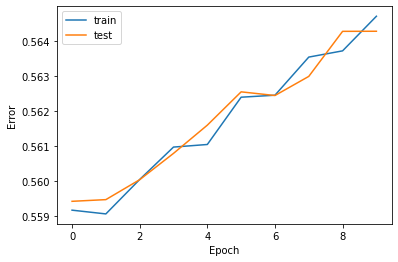

In [23]:
rbms = []
for i in range(2):
    rbm = create_rbm(train_matrix, test_matrix, 5, 2000, 10, train_errors=[], test_errors=[])[0]
    print(f"RBM {i}")
    evaluate_rbm(rbm)
    torch.save(rbm.state_dict(), f"./rbm5-10-nr{i}.network")
    rbms.append(rbm)


# recommend for single user

In [ ]:
def recommend(rbm, v, vt, k, p=True):
    """
    use our model to get recommendations for a single user to reach qualitative metrics
    :param rbm: our model
    :param v: 
    :param vt: 
    :param k: 
    :param p: 
    :return: 
    """
    target_data = vt.data
    target_index = vt.indices
    target_recommendations = target_index[target_data == 1]
    v = v.todense()
    v = torch.Tensor(v)
    if torch.cuda.is_available():
        v = v.cuda()
    
    _, h = rbm.sample_h(v)
    recommended, _ = rbm.sample_v(h)

    # all recommendations
    values, indices =  torch.topk(recommended[v < 1], k)
    recommendations = indices.cpu().tolist()

    if p:
        print("average value", torch.mean(recommended[0]))

    found = True
    for r in recommendations:
        if r in target_recommendations:
            if p:
                print("HIT")
            found = True
            break

    if found and p:
        print("values", values)
        print("recommended", recommendations)
        print("real", target_recommendations)
        print("len real", len(target_recommendations))

    
    
    return recommendations

user = 100





## Hyperparam searching

In [ ]:
epochs = [5, 10, 25, 50, 100]
hidden = [10, 25, 50, 75, 100]
rbms = []
results = {}

for n_hidden in hidden:
    rbm = None
    prev_epoch = 0
    train = []
    test = []
    for epoch in epochs:
        rbm, train, test = create_rbm(train_matrix, test_matrix, n_hidden, 2000, epoch - prev_epoch, rbm, train_errors=train, test_errors=test)
        torch.save(rbm.state_dict(), f"./network-{n_hidden}-steam{epoch}-train0")

        hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
        results[f"{epoch}-{n_hidden}"] = (np.average(hr), np.average(r), np.average(ndcg))
        prev_epoch = epoch
    rbms.append(rbm)



start training


100%|██████████| 31/31 [00:07<00:00,  4.09it/s]


start training


100%|██████████| 31/31 [00:07<00:00,  4.15it/s]


start training


 74%|███████▍  | 23/31 [00:06<00:02,  3.57it/s]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

# Ensemble of ANTI-RBM

In [35]:
def compute_ensemble_hr(train_matrix, test_matrix, rbms: list[RBM], k=10, rating_cutoff=-1, p=False):
    """
    compute the various metrics of our model, hr, recall and ndcg
    :param train_matrix: the input wich our user already has
    :param test_matrix: the games we are trying to recommend to each user
    :param rbm: our model used to make recommendations
    :param k: the amount of recommendations we are going to give
    :param batch_size: UNUSED, uses rbm.batch_size instead
    :return: hitrates, recall, nDCG as an array, use np.average to get value
    """
    hitrates = []
    recall = []
    nDCG = []
    batch_size = rbms[0].batch_size

    recommended_games_set = set()
    # for loop - go through every single user
    # for id_user in tqdm(range(0, train_matrix.shape[0] - rbm.batch_size, rbm.batch_size)): # - batch_size, batch_size):
    for id_user in trange(0, train_matrix.shape[0] - batch_size, batch_size): # - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        if vt.getnnz() == 0:
            continue

        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)
        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)

        if torch.cuda.is_available():
            vt = vt.cuda()
            v = v.cuda()

        # ground truth
        ratings, users, movies = (vt > 0).nonzero(as_tuple=True)

        indices = torch.stack([users, movies])
        shape = (batch_size, train_matrix.shape[1])
        target = torch.sparse.LongTensor(indices, torch.add(ratings, 1), torch.Size(shape))
        target_dense = target.to_dense()

        target_recommended = torch.argsort(target_dense, 1, descending=True)

        # predicted
        pred_ratings = []
        pred_movies = []
        for rbm in rbms:
            _, h = rbm.sample_h(v)
            recommended, _ = rbm.sample_v(h)

            scaled_tensors = [recommended[0]]
            for i in range(1, rbm.K):
                scaled_tensors.append(recommended[i] * (i+1))
            recommended_scaled = torch.stack(scaled_tensors)
            recommended_summed = torch.sum(recommended_scaled, 0)
            pred_rating, pred_movie = torch.topk(recommended_summed, k)
            pred_ratings.append(pred_rating)
            pred_movies.append(pred_movie)

        predicted_ratings = torch.cat(pred_ratings, dim=1)
        predicted_movies = torch.cat(pred_movies, dim=1)
        _, predicted_indices = torch.topk(predicted_ratings, k)


        for user in range(batch_size):
            # all recommendations
            user_ratings = torch.index_select(target_dense[user], 0, target_recommended[user])
            user_target = target_recommended[user][user_ratings > 0].cpu().tolist()

            # user_target = target_recommended[user][target_rating[user] > rating_cutoff].cpu().tolist()
            user_pred = torch.index_select(predicted_movies[user], 0, predicted_indices[0])

            recommended_games_set = recommended_games_set.union(set(user_pred))
            counter = 0
            total = min(k, len(user_target))
            for target in user_target:
                if target in user_pred:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(user_target)))])
            dcg = 0
            for i, r in enumerate(user_pred):
                if r in user_target:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    if p:
        print(recommended_games_set)
        print(len(recommended_games_set))
    return hitrates, recall, nDCG


In [36]:
hr, r, ndcg = compute_ensemble_hr(train_matrix, test_matrix, rbms)
print(np.average(hr), np.average(r), np.average(ndcg))

KeyboardInterrupt: 